# Models 2
- This notebook attempts to improve performance from the first [modeling notebook](./models_1.ipynb).
- We will use __PyTorch dense neural networks__ to attempt this task.

## Imports, Load Data

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

# some preprocessing/metric packages from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error

# Bayesian optimization
from bayes_opt import BayesianOptimization

# dataframe display
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# seaborn theme
sns.set_theme(context='talk', style='whitegrid')

# global random_state
random_state = 9

In [29]:
# set up GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [30]:
df = pd.read_csv('./train_data/data.csv').drop(['Unnamed: 0'], axis=1)

In [31]:
# 2022 players with 2023 target (test set)
players_2022 = df[df['year'] == 2022]

# drop these rows from training data
df = df.drop(players_2022.index)

# Functions

## create_loaders
- Create pytorch dataloaders in 5 different splits to employ KFold cross validation.

In [85]:
def create_loaders(feature_subset, batch_size, df=df, random_state=random_state):
    '''
    
    
    Create train and validation dataloaders split in 5 ways from the master df using the specified feature set. 
    
    Parameters:
    feature_subset (list) - features to be used from master dataframe
    batch_size (int) - batch size to be used in the training dataloader
    
    
    
    Returns:
    dataloaders (list) - list of 10 pytorch dataloaders (5 train and 5 validation)
    
    
    
    '''

    
    
    # features and target
    X = df[feature_subset]
    y = df.target
    
    # convert target data to tensor
    y = torch.tensor(y.values, dtype=torch.float32)
    
    
    
    # use KFold cross validation with 5 splits
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

    # indices to split on
    splits = kf.split(X)

    # list to store each set of (train, val) dataloaders
    dataloaders = []

    for fold, (train_idx, val_idx) in enumerate(splits):
        
        # split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]    
        
        # create scaler, scale data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # convert scaled data to tensors
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_train_tensor = y_train
        y_val_tensor = y_val
        
        # create datasets
        train_data = TensorDataset(X_train_tensor, y_train_tensor)
        val_data = TensorDataset(X_val_tensor, y_val_tensor)

        # create dataloaders for training and validation sets
        if batch_size in [5, 25, 31]: # these 3 batch sizes result in a final batch with 1 sample, which causes error
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True) # drop last batch
        else:
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

        # store in list
        dataloaders.append((train_loader, val_loader))

    return dataloaders

## kfold_val
- Once again, 5-split KFold cross validation is used to evaluate model performance.

In [50]:
def kfold_val(dataloaders, hidden_units, dropout_rate, lr, patience=15, device=device):
    '''
    
    
    Train and validate a model on 5 splits. Returns averaged performance metrics from the 5 folds.
    
    
    
    Parameters:
    dataloaders (list) - list of torch dataloaders
    hidden_units (list) - list that contains nodes for each hidden layer of the NN
    dropout_rate (float) - dropout rate to be used in NN
    lr (float) - learning rate to be used in optimizer
    patience (int) - patience of early stopping. If avg kfold loss goes this many epochs without reaching a new lowest loss, 
    exit loop
    
    

    '''
    
    # loss function
    criterion = nn.MSELoss()
    
    # epochs
    num_epochs = 500

    # store val loss and r2 for each fold
    train_fold_rmse = []
    train_fold_r2 = []
    val_fold_rmse = []
    val_fold_r2 = []

    # KFold loop, 5 iterations for 5 splits
    for fold, (train_loader, val_loader) in enumerate(dataloaders):
        
        # early stopping
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        
        # initialize model, move params to gpu
        model = dense_nn(input_dim=val_loader.dataset[0][0].shape[0], hidden_dim1=hidden_units[0], hidden_dim2=hidden_units[1], 
                         hidden_dim3=hidden_units[2], hidden_dim4=hidden_units[3], hidden_dim5=hidden_units[4], 
                         hidden_dim6=hidden_units[5], dropout_rate=dropout_rate).to(device)

        # create optimizer
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        
        
        # train loop
        for epoch in range(num_epochs):
            # sum of squared error, preds, and y. reset at the start of every epoch
            sse = 0
            epoch_preds = []
            epoch_y = []

            # set model to training mode
            model.train()
            for x, y in train_loader:
                # move data to gpu
                x = x.to(device)
                y = y.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward pass
                train_preds = model(x).squeeze(-1)
                # calc loss
                train_loss = criterion(train_preds, y)
                # backward pass
                train_loss.backward()
                # optimize
                optimizer.step()

                # accumulate squared errors
                sse += ((train_preds - y) ** 2).sum().item()

                # get preds and y from batch to calc r2
                epoch_preds.extend(train_preds.numpy(force=True))
                epoch_y.extend(y.numpy(force=True))

            # train metrics
            train_rmse = np.sqrt(sse / len(train_loader.dataset))
            train_r2 = r2_score(epoch_y, epoch_preds)



            # validation
            model.eval()

            with torch.inference_mode():
                for x, y in val_loader:
                    # move data to gpu
                    x = x.to(device)
                    y = y.to(device)
                
                    # forward pass
                    val_preds = model(x).squeeze(-1)
                    # calc loss
                    val_loss = criterion(val_preds, y)

            # val metrics
            val_rmse = np.sqrt(((val_preds - y) ** 2).sum().item() / y.shape[0])
            val_r2 = r2_score(y.numpy(force=True), val_preds.numpy(force=True))



            # early stopping
            if val_rmse < best_val_loss:
                best_val_loss = val_rmse
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

                # break out of train loop if we reach patience value
                if epochs_without_improvement == patience:
                    print(f'Early stopping on Epoch {epoch + 1}.')
                    break

        
        
        # append metrics at the end of a fold
        train_fold_rmse.append(train_rmse)
        train_fold_r2.append(train_r2)
        val_fold_rmse.append(val_rmse)
        val_fold_r2.append(val_r2)
        
        # delete model, optimizer, release occupied gpu memory
        del model
        del optimizer
        torch.cuda.empty_cache()
        
    return np.mean(train_fold_rmse), np.mean(train_fold_r2), np.mean(val_fold_rmse), np.mean(val_fold_r2), patience

# NN class

In [56]:
class dense_nn(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, dropout_rate):
        super(dense_nn, self).__init__()
        
        # hidden layers with batch norm
        self.h1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.h3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.h4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.bn4 = nn.BatchNorm1d(hidden_dim4)
        self.h5 = nn.Linear(hidden_dim4, hidden_dim5)
        self.bn5 = nn.BatchNorm1d(hidden_dim5)
        self.h6 = nn.Linear(hidden_dim5, hidden_dim6)
        self.bn6 = nn.BatchNorm1d(hidden_dim6)
        
        # activation function
        self.a = nn.ReLU()
        
        # dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # output layer
        self.output = nn.Linear(hidden_dim6, 1)
        
        
        
    def forward(self, x):
        # hidden layer, then batch norm, activation function, then dropout
        x = self.a(self.bn1(self.h1(x)))
        x = self.dropout(x)
        
        x = self.a(self.bn2(self.h2(x)))
        x = self.dropout(x)
        
        x = self.a(self.bn3(self.h3(x)))
        x = self.dropout(x)
        
        x = self.a(self.bn4(self.h4(x)))
        x = self.dropout(x)
        
        x = self.a(self.bn5(self.h5(x)))
        x = self.dropout(x)
        
        x = self.a(self.bn6(self.h6(x)))
        x = self.dropout(x)
        
        # output layer
        x = self.output(x)
        
        return x

# Bayesian Optimization
- Iterating through parameter space to find best Dense NN.

In [57]:
# all features
all_feats = df.drop(['player', 'team_name', 'year', 'target'], axis=1).columns.tolist()

## 3-layer NN

In [36]:
def objective_function(hidden_dim1, hidden_dim2, hidden_dim3, dropout_rate, batch_size):
    # cast continuous values to int
    hidden_dim1 = int(hidden_dim1)
    hidden_dim2 = int(hidden_dim2)
    hidden_dim3 = int(hidden_dim3)
    batch_size = int(batch_size)
    
    # create data
    dataloaders = create_loaders(feature_subset=all_feats, batch_size=batch_size)
    
    # pack hidden dim into list
    hidden_units = [hidden_dim1, hidden_dim2, hidden_dim3]
    
    # train model
    train_rmse, train_r2, val_rmse, val_r2, patience = kfold_val(dataloaders, hidden_units, dropout_rate=dropout_rate, lr=0.001)
    
    # return the negative of the validation metric (since Bayesian optimization minimizes)
    return -val_rmse

In [37]:
# define bounds of each hyperparameter
pbounds = {
    'hidden_dim1': (2, 513),
    'hidden_dim2': (2, 513),
    'hidden_dim3': (2, 513),
    'dropout_rate': (0, 0.9),
    'batch_size': (1, 129)
}

# create the Bayesian optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=random_state,
    allow_duplicate_points=True
)

In [38]:
# iterate through feature space
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | batch_... | dropou... | hidden... | hidden... | hidden... |
-------------------------------------------------------------------------------------
Early stopping on Epoch 33.
Early stopping on Epoch 43.
Early stopping on Epoch 42.
Early stopping on Epoch 24.
Early stopping on Epoch 24.
| 1         | -21.92    | 2.328     | 0.4517    | 255.3     | 70.39     | 74.62     |
Early stopping on Epoch 56.
Early stopping on Epoch 45.
Early stopping on Epoch 62.
Early stopping on Epoch 44.
Early stopping on Epoch 44.
| 2         | -14.17    | 28.98     | 0.3767    | 128.8     | 44.95     | 178.5     |
Early stopping on Epoch 51.
Early stopping on Epoch 28.
Early stopping on Epoch 46.
Early stopping on Epoch 55.
Early stopping on Epoch 198.
| 3         | -28.29    | 22.35     | 0.7907    | 487.9     | 21.8      | 359.2     |
Early stopping on Epoch 81.
Early stopping on Epoch 78.
Early stopping on Epoch 83.
Early stopping on Epoch 73.
Early stopping on Epoch 66.
| 4      

Early stopping on Epoch 177.
Early stopping on Epoch 156.
| 29        | -23.18    | 92.08     | 0.5573    | 227.1     | 16.81     | 66.87     |
Early stopping on Epoch 52.
Early stopping on Epoch 53.
Early stopping on Epoch 70.
Early stopping on Epoch 56.
Early stopping on Epoch 47.
| 30        | -12.6     | 57.85     | 0.4864    | 90.14     | 377.1     | 261.5     |
Early stopping on Epoch 82.
Early stopping on Epoch 76.
Early stopping on Epoch 78.
Early stopping on Epoch 86.
Early stopping on Epoch 75.
| 31        | -13.39    | 94.66     | 0.3537    | 223.5     | 275.4     | 197.1     |
Early stopping on Epoch 22.
Early stopping on Epoch 23.
Early stopping on Epoch 21.
Early stopping on Epoch 22.
Early stopping on Epoch 21.
| 32        | -19.18    | 4.332     | 0.8373    | 274.5     | 258.6     | 159.8     |
Early stopping on Epoch 112.
Early stopping on Epoch 91.
Early stopping on Epoch 122.
Early stopping on Epoch 98.
Early stopping on Epoch 105.
| 33        | -13.38    | 109.5    

Early stopping on Epoch 132.
Early stopping on Epoch 120.
| 58        | -14.52    | 97.61     | 0.1942    | 173.6     | 194.6     | 89.41     |
Early stopping on Epoch 33.
Early stopping on Epoch 76.
Early stopping on Epoch 26.
Early stopping on Epoch 18.
Early stopping on Epoch 34.
| 59        | -18.12    | 3.369     | 0.2064    | 420.7     | 108.4     | 452.0     |
Early stopping on Epoch 59.
Early stopping on Epoch 89.
Early stopping on Epoch 84.
Early stopping on Epoch 56.
Early stopping on Epoch 74.
| 60        | -13.69    | 77.15     | 0.6834    | 296.8     | 420.3     | 344.8     |
Early stopping on Epoch 86.
Early stopping on Epoch 93.
Early stopping on Epoch 91.
Early stopping on Epoch 121.
Early stopping on Epoch 119.
| 61        | -13.37    | 73.38     | 0.3365    | 45.76     | 359.3     | 91.42     |
Early stopping on Epoch 250.
Early stopping on Epoch 252.
Early stopping on Epoch 238.
Early stopping on Epoch 313.
Early stopping on Epoch 265.
| 62        | -25.62    | 103.8

Early stopping on Epoch 140.
Early stopping on Epoch 136.
Early stopping on Epoch 104.
| 87        | -28.23    | 117.0     | 0.8054    | 226.2     | 32.29     | 176.5     |
Early stopping on Epoch 98.
Early stopping on Epoch 112.
Early stopping on Epoch 121.
Early stopping on Epoch 114.
Early stopping on Epoch 85.
| 88        | -15.51    | 108.0     | 0.6143    | 361.5     | 77.47     | 199.4     |
Early stopping on Epoch 106.
Early stopping on Epoch 83.
Early stopping on Epoch 67.
Early stopping on Epoch 76.
Early stopping on Epoch 76.
| 89        | -14.27    | 99.26     | 0.4258    | 8.374     | 346.1     | 314.7     |
Early stopping on Epoch 43.
Early stopping on Epoch 49.
Early stopping on Epoch 71.
Early stopping on Epoch 43.
Early stopping on Epoch 43.
| 90        | -13.07    | 55.62     | 0.4387    | 430.1     | 247.8     | 483.5     |
Early stopping on Epoch 52.
Early stopping on Epoch 55.
Early stopping on Epoch 78.
Early stopping on Epoch 75.
Early stopping on Epoch 51.
| 91 

In [39]:
# look at params that gave lowest validation RMSE
best_hyperparams = optimizer.max['params']
best_hyperparams

{'batch_size': 114.00543105078356,
 'dropout_rate': 0.5339961254683491,
 'hidden_dim1': 81.52752276915427,
 'hidden_dim2': 505.8309031217294,
 'hidden_dim3': 428.1517727969641}

- Best val_rmse = __12.53__ for the 3-layer NN.

## 6-layer NN

In [58]:
def objective_function(hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, dropout_rate, batch_size):
    # cast continuous values to int
    hidden_dim1 = int(hidden_dim1)
    hidden_dim2 = int(hidden_dim2)
    hidden_dim3 = int(hidden_dim3)
    hidden_dim4 = int(hidden_dim4)
    hidden_dim5 = int(hidden_dim5)
    hidden_dim6 = int(hidden_dim6)
    batch_size = int(batch_size)
    
    # create data
    dataloaders = create_loaders(feature_subset=all_feats, batch_size=batch_size)
    
    # pack hidden dim into list
    hidden_units = [hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6]
    
    # train model
    train_rmse, train_r2, val_rmse, val_r2, patience = kfold_val(dataloaders, hidden_units, dropout_rate=dropout_rate, lr=0.001)
    
    # return the negative of the validation metric (since Bayesian optimization minimizes)
    return -val_rmse

In [59]:
# define bounds of each hyperparameter
pbounds = {
    'hidden_dim1': (2, 513),
    'hidden_dim2': (2, 513),
    'hidden_dim3': (2, 513),
    'hidden_dim4': (2, 513),
    'hidden_dim5': (2, 513),
    'hidden_dim6': (2, 513),
    'dropout_rate': (0, 0.9),
    'batch_size': (2, 129)
}

# create the Bayesian optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=random_state,
    allow_duplicate_points=True
)

In [86]:
# iterate through feature space
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | batch_... | dropou... | hidden... | hidden... | hidden... | hidden... | hidden... | hidden... |
-------------------------------------------------------------------------------------------------------------------------
Early stopping on Epoch 47.
Early stopping on Epoch 47.
Early stopping on Epoch 54.
Early stopping on Epoch 53.
Early stopping on Epoch 48.
| 79        | -13.95    | 65.51     | 0.07519   | 406.4     | 389.4     | 136.0     | 53.54     | 470.7     | 266.4     |
Early stopping on Epoch 34.
Early stopping on Epoch 34.
Early stopping on Epoch 50.
Early stopping on Epoch 38.
Early stopping on Epoch 31.
| 80        | -13.77    | 18.96     | 0.1013    | 432.1     | 281.0     | 135.4     | 296.2     | 162.4     | 406.5     |
Early stopping on Epoch 63.
Early stopping on Epoch 100.
Early stopping on Epoch 69.
Early stopping on Epoch 76.
Early stopping on Epoch 55.
| 81        | -20.03    | 64.62     | 0.8686    | 267.9     | 463.4     | 129.7     | 268.5

Early stopping on Epoch 65.
Early stopping on Epoch 53.
Early stopping on Epoch 49.
| 102       | -13.57    | 83.42     | 0.09905   | 414.0     | 44.98     | 198.8     | 186.8     | 61.9      | 356.9     |
Early stopping on Epoch 68.
Early stopping on Epoch 53.
Early stopping on Epoch 46.
Early stopping on Epoch 57.
Early stopping on Epoch 64.
| 103       | -26.44    | 44.88     | 0.7597    | 321.6     | 263.2     | 220.2     | 172.2     | 167.4     | 489.5     |
Early stopping on Epoch 96.
Early stopping on Epoch 99.
Early stopping on Epoch 92.
Early stopping on Epoch 109.
Early stopping on Epoch 95.
| 104       | -12.97    | 92.32     | 0.2528    | 324.8     | 123.9     | 496.7     | 76.12     | 105.3     | 132.6     |
Early stopping on Epoch 42.
Early stopping on Epoch 30.
Early stopping on Epoch 82.
Early stopping on Epoch 65.
Early stopping on Epoch 51.
| 105       | -13.2     | 10.27     | 0.2659    | 150.3     | 167.8     | 60.29     | 169.2     | 45.47     | 99.94     |
Early s

Early stopping on Epoch 60.
Early stopping on Epoch 82.
Early stopping on Epoch 83.
Early stopping on Epoch 69.
| 126       | -12.41    | 83.64     | 0.4538    | 71.04     | 159.7     | 490.9     | 363.8     | 183.4     | 300.8     |
Early stopping on Epoch 60.
Early stopping on Epoch 93.
Early stopping on Epoch 79.
Early stopping on Epoch 64.
Early stopping on Epoch 65.
| 127       | -29.69    | 49.05     | 0.6658    | 226.5     | 479.3     | 102.5     | 510.3     | 126.3     | 221.6     |
Early stopping on Epoch 101.
Early stopping on Epoch 81.
Early stopping on Epoch 82.
Early stopping on Epoch 71.
Early stopping on Epoch 70.
| 128       | -15.67    | 64.17     | 0.8605    | 48.94     | 509.7     | 441.2     | 378.7     | 306.4     | 142.6     |
Early stopping on Epoch 77.
Early stopping on Epoch 63.
Early stopping on Epoch 104.
Early stopping on Epoch 82.
Early stopping on Epoch 84.
| 129       | -36.69    | 96.54     | 0.6844    | 510.6     | 485.3     | 137.8     | 399.0     | 12

Early stopping on Epoch 127.
Early stopping on Epoch 41.
Early stopping on Epoch 50.
Early stopping on Epoch 46.
Early stopping on Epoch 37.
| 150       | -19.4     | 24.26     | 0.6266    | 458.4     | 108.7     | 328.1     | 124.3     | 165.1     | 330.2     |
Early stopping on Epoch 85.
Early stopping on Epoch 84.
Early stopping on Epoch 130.
Early stopping on Epoch 106.
Early stopping on Epoch 83.
| 151       | -27.89    | 111.7     | 0.6877    | 477.4     | 213.4     | 257.1     | 362.7     | 302.6     | 208.9     |
Early stopping on Epoch 81.
Early stopping on Epoch 64.
Early stopping on Epoch 79.
Early stopping on Epoch 70.
Early stopping on Epoch 71.
| 152       | -13.0     | 103.7     | 0.3695    | 442.0     | 444.5     | 449.6     | 481.1     | 355.8     | 314.8     |
Early stopping on Epoch 98.
Early stopping on Epoch 95.
Early stopping on Epoch 125.
Early stopping on Epoch 93.
Early stopping on Epoch 105.
| 153       | -12.63    | 85.7      | 0.4159    | 437.8     | 317.0  

Early stopping on Epoch 118.
Early stopping on Epoch 123.
Early stopping on Epoch 158.
Early stopping on Epoch 159.
Early stopping on Epoch 137.
| 174       | -12.75    | 123.6     | 0.5889    | 417.4     | 128.0     | 101.3     | 213.1     | 506.1     | 131.1     |
Early stopping on Epoch 50.
Early stopping on Epoch 58.
Early stopping on Epoch 62.
Early stopping on Epoch 81.
Early stopping on Epoch 73.
| 175       | -13.97    | 92.44     | 0.1575    | 95.61     | 456.7     | 488.6     | 4.695     | 134.7     | 494.7     |
Early stopping on Epoch 63.
Early stopping on Epoch 98.
Early stopping on Epoch 74.
Early stopping on Epoch 85.
Early stopping on Epoch 84.
| 176       | -45.54    | 96.68     | 0.6829    | 18.7      | 419.8     | 78.46     | 499.9     | 76.38     | 511.6     |
Early stopping on Epoch 72.
Early stopping on Epoch 68.
Early stopping on Epoch 66.
Early stopping on Epoch 65.
Early stopping on Epoch 68.
| 177       | -12.67    | 112.3     | 0.4357    | 482.1     | 338.8  

In [87]:
# look at params that gave lowest validation RMSE
best_hyperparams = optimizer.max['params']
best_hyperparams

{'batch_size': 62.82287881109294,
 'dropout_rate': 0.3973949766395167,
 'hidden_dim1': 36.861369587689516,
 'hidden_dim2': 256.05014822924625,
 'hidden_dim3': 477.9048850032978,
 'hidden_dim4': 339.7387922248759,
 'hidden_dim5': 307.78576882621445,
 'hidden_dim6': 356.457657281856}

- Best val_rmse = __12.37__ for the 6-layer NN. This is the best validation performance recorded, so this 6-layer model will be used for the predictions below.

# 2023 predictions
- This model will be trained on the entire train/val data, and then will predict 2023 offensive grade from the 2022 holdout set.

In [88]:
# features and target
X_train = df[grades_only]
y_train = df.target
X_test = players_2022[grades_only]
y_test = players_2022.target

# convert target data to tensor
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# create scaler, scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# create datasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# create dataloaders
train_loader = DataLoader(train_data, batch_size=62, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [231]:
# best NN
best_model = dense_nn(input_dim=len(grades_only), hidden_dim1=36, hidden_dim2=256, hidden_dim3=477, hidden_dim4=339, 
                      hidden_dim5=307, hidden_dim6=356, dropout_rate=0.4).to(device)

In [232]:
# train best_model

# loss function
criterion = nn.MSELoss()

# 50 epochs
num_epochs = 50

# create optimizer
optimizer = optim.AdamW(best_model.parameters(), lr=0.001)

# train loop
for epoch in range(num_epochs):
    # sum of squared error, preds, and y. reset at the start of every epoch
    sse = 0
    epoch_preds = []
    epoch_y = []

    # set best_model to training mode
    best_model.train()
    for x, y in train_loader:
        # move data to gpu
        x = x.to(device)
        y = y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        train_preds = best_model(x).squeeze(-1)
        # calc loss
        train_loss = criterion(train_preds, y)
        # backward pass
        train_loss.backward()
        # optimize
        optimizer.step()

        # accumulate squared errors
        sse += ((train_preds - y) ** 2).sum().item()

        # get preds and y from batch to calc r2
        epoch_preds.extend(train_preds.numpy(force=True))
        epoch_y.extend(y.numpy(force=True))

    # train metrics
    train_rmse = np.sqrt(sse / len(train_loader.dataset))
    train_r2 = r2_score(epoch_y, epoch_preds)
    
print('Final training metrics from best model:')
print(f'RMSE = {train_rmse}')
print(f'R^2 = {train_r2}')

Final training metrics from best model:
RMSE = 13.354779006857578
R^2 = 0.20136528923173524


In [233]:
# predict with model on 2022 data
best_model.eval()

with torch.inference_mode():
    for x, y in test_loader:
        # move data to gpu
        x = x.to(device)
        y = y.to(device)

        # forward pass
        test_preds = best_model(x).squeeze(-1)
        # calc loss
        test_loss = criterion(test_preds, y)

# test metrics
test_rmse = np.sqrt(((test_preds - y) ** 2).sum().item() / y.shape[0])
test_r2 = r2_score(y.numpy(force=True), test_preds.numpy(force=True))

print('Final test metrics from best model:')
print(f'RMSE = {test_rmse}')
print(f'R^2 = {test_r2}')

Final test metrics from best model:
RMSE = 12.54209789324745
R^2 = 0.3589741501339716


- Using the best dense NN, we achieved an __RMSE of 12.54__ and a __R^2 of 0.36__. These numbers are worse than the results from the Random Forest.
- Still going to plot predictions below to analyze the variation of the two different prediction sets.

In [234]:
# convert tensors back to ndarrays
test_preds = test_preds.numpy(force=True)

# create a df for our predictions
preds_df = pd.DataFrame(data={'player': players_2022['player'].values, 'team': players_2022['team_name'].values, 
                              'y_true': y_test, 'y_pred': test_preds, 'error': (test_preds - y_test)})

In [235]:
# team colors for plotting predictions
nfl_team_colors = {
    'GB': '#203731',   # Green Bay Packers
    'NO': '#D3BC8D',   # New Orleans Saints
    'LA': '#003594',   # Los Angeles Rams
    'DAL': '#041E42',  # Dallas Cowboys
    'NYG': '#0B2265',  # New York Giants
    'LV': '#000000',   # Las Vegas Raiders
    'SEA': '#002244',  # Seattle Seahawks
    'PHI': '#004C54',  # Philadelphia Eagles
    'DET': '#0076B6',  # Detroit Lions
    'SF': '#AA0000',   # San Francisco 49ers
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'BUF': '#00338D',  # Buffalo Bills
    'CHI': '#0B162A',  # Chicago Bears
    'LAC': '#0080C6',  # Los Angeles Chargers
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'MIN': '#4F2683',  # Minnesota Vikings
    'ARZ': '#97233F',  # Arizona Cardinals
    'BLT': '#241773',  # Baltimore Ravens
    'NE': '#002244',   # New England Patriots
    'KC': '#E31837',   # Kansas City Chiefs
    'DEN': '#FB4F14',  # Denver Broncos
    'TEN': '#0C2340',  # Tennessee Titans
    'WAS': '#773141',  # Washington Commanders
    'JAX': '#006778',  # Jacksonville Jaguars
    'MIA': '#008E97',  # Miami Dolphins
    'NYJ': '#125740',  # New York Jets
    'TB': '#D50A0A',   # Tampa Bay Buccaneers
    'CLV': '#311D00',  # Cleveland Browns
    'ATL': '#A71930',  # Atlanta Falcons
    'CAR': '#0085CA',  # Carolina Panthers
}

# map colors to our preds_df
preds_df['color'] = preds_df['team'].map(nfl_team_colors)

In [236]:
# show 2023 predictions for all 48 QBs
preds_df.sort_values('error')[['player', 'y_true', 'y_pred', 'error']].T

,440,62,606,732,282,509,987,976,54,516,831,542,579,142,1008,781,920,425,878,397,165,540,1017,334,558,545,433,863,385,133,329,481,877,478,601,291,273,335,116,616,617,748,991,91,57,775,754,22
player,Jared Goff,Baker Mayfield,Lamar Jackson,Matthew Stafford,Dak Prescott,Jordan Love,Tua Tagovailoa,Trevor Lawrence,Andy Dalton,Josh Allen,Russell Wilson,Justin Fields,Kirk Cousins,Brock Purdy,Tyrod Taylor,Patrick Mahomes,Taylor Heinicke,Jalen Hurts,Sam Howell,Geno Smith,C.J. Beathard,Joshua Dobbs,Zach Wilson,Deshaun Watson,Kenny Pickett,Justin Herbert,Jameis Winston,Ryan Tannehill,Gardner Minshew,Brian Hoyer,Derek Carr,Joe Burrow,Sam Darnold,Jimmy Garoppolo,Kyler Murray,Daniel Jones,Cooper Rush,Desmond Ridder,Brett Rypien,Mac Jones,Malik Willis,Mike White,Tyler Huntley,Blaine Gabbert,Bailey Zappe,P.J. Walker,Mitch Trubisky,Aaron Rodgers
y_true,90.6,73.3,87.5,83.7,87.6,71.3,87.5,82.7,81.1,89.8,77.1,73.6,86.1,78.1,66.8,87.1,65.3,81.3,67.5,75.3,66.2,66.3,59.9,66.9,66.8,77.8,67.7,72.0,56.6,57.9,68.1,78.0,59.8,65.6,65.6,63.0,53.1,48.9,48.1,59.0,45.9,46.2,45.2,40.2,41.3,30.8,34.8,39.4
y_pred,68.405602,55.468418,69.999641,66.617546,71.736046,55.879078,73.972832,69.231407,68.687401,77.755653,66.544624,63.189793,75.691765,67.970299,58.322369,79.012054,57.749405,74.440765,62.685833,70.65242,61.683319,62.106869,56.105801,63.568199,64.027016,75.417778,65.400681,70.473152,55.556358,57.767056,68.16555,78.208046,60.535038,66.661011,67.637253,65.573181,57.064991,55.580528,55.633507,66.63726,56.476734,58.008018,57.129452,60.575508,64.32486,55.370163,62.261261,75.482002
error,-22.194398,-17.831582,-17.500359,-17.082454,-15.863954,-15.420922,-13.527168,-13.468593,-12.412599,-12.044347,-10.555376,-10.410207,-10.408235,-10.129701,-8.477631,-8.087946,-7.550595,-6.859235,-4.814167,-4.64758,-4.516681,-4.193131,-3.794199,-3.331801,-2.772984,-2.382222,-2.299319,-1.526848,-1.043642,-0.132944,0.06555,0.208046,0.735038,1.061011,2.037253,2.573181,3.964991,6.680528,7.533507,7.63726,10.576734,11.808018,11.929452,20.375508,23.02486,24.570163,27.461261,36.082002


In [237]:
# percent of preds within 10 pts
percent = (preds_df.error.abs() < 10).sum() / len(preds_df)

print(f'{percent*100:.1f}% of our model\'s predictions are within 10pts of the true value.')

54.2% of our model's predictions are within 10pts of the true value.


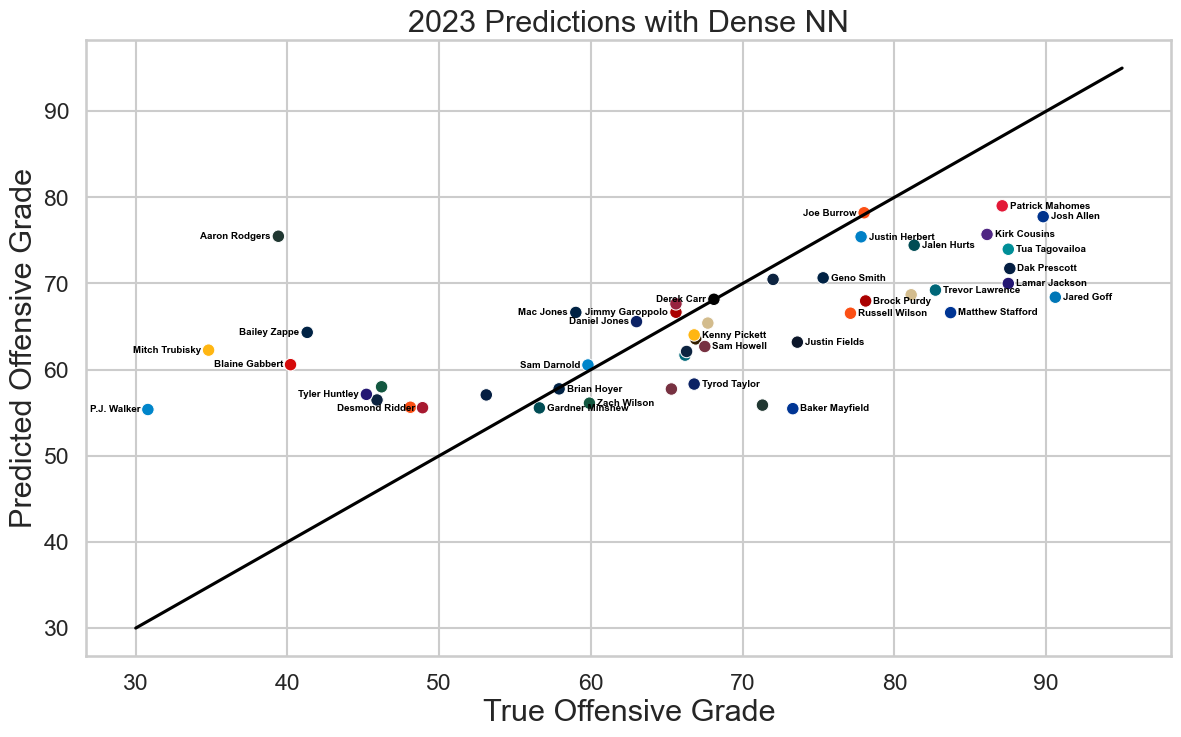

In [246]:
# visualize 2023 predictions
plt.figure(figsize=(14, 8))

# lists of players to NOT annotate
over_drops = ['Mike White', 'Cooper Rush', 'C.J. Beathard', 'Joshua Dobbs', 'Brett Rypien', 'Malik Willis', 'Kyler Murray']
under_drops = ['Jameis Winston', 'Taylor Heinicke', 'Ryan Tannehill', 'Andy Dalton', 'Derek Carr', 'C.J. Beathard', 
               'Deshaun Watson', 'Joshua Dobbs', 'Jordan Love']

# title, labels
plt.title('2023 Predictions with Dense NN', fontsize=22)
plt.xlabel('True Offensive Grade', fontsize=22)
plt.ylabel('Predicted Offensive Grade', fontsize=22)

# team colors
color_palette = {color: color for color in preds_df['color'].unique()}

# plot players as points
sns.scatterplot(data=preds_df, x='y_true', y='y_pred', hue='color', palette=color_palette, legend=False)

# plot line to show perfect predictions
sns.lineplot(x=range(30,96), y=range(30,96), color='black')

# annotating each point with the player's name
for index, row in preds_df.iterrows():
    # over preds (above line)
    if (row['y_pred'] > row['y_true']) and (row['player'] not in over_drops):
        plt.text(row['y_true']-0.5, row['y_pred']-0.3, row['player'], horizontalalignment='right', color='black', 
             weight='semibold', fontsize=7)
    # under preds (below line)
    elif (row['y_pred'] < row['y_true']) and (row['player'] not in under_drops):
        plt.text(row['y_true']+0.5, row['y_pred']-0.3, row['player'], horizontalalignment='left', color='black', 
             weight='semibold', fontsize=7)
             
plt.savefig('./images/preds_2');

In [247]:
# all 48 QBs
print(f'Normal RMSE: {mean_squared_error(y_test, test_preds, squared=False)}')
print(f'Normal R^2 : {r2_score(y_test, test_preds)}\n')

# without aaron rodgers
print(f'Dropping Aaron Rodgers - RMSE: {mean_squared_error(y_test[1:], test_preds[1:], squared=False)}')
print(f'Dropping Aaron Rodgers - R^2 : {r2_score(y_test[1:], test_preds[1:])}')

Normal RMSE: 12.542098176210581
Normal R^2 : 0.3589741507712355

Dropping Aaron Rodgers - RMSE: 11.530433359752704
Dropping Aaron Rodgers - R^2 : 0.4338742490515741


In [248]:
# percent of preds within 10 pts
percent = (preds_df[1:].error.abs() < 10).sum() / (len(preds_df) - 1)

print(f'Excluding Aaron Rodgers, {percent*100:.1f}% of our model\'s predictions are within 10pts of the true value.')

Excluding Aaron Rodgers, 55.3% of our model's predictions are within 10pts of the true value.


# Conclusion
- Even after evaluating many different dense NNs, our results were noticeably worse than the best Random Forest found in [this notebook](./models_1.ipynb).